<a href="https://www.kaggle.com/code/siddp6/live-internet-browsing-using-llm?scriptVersionId=219115337" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🧠 Building a Simple LangChain Agent with LangGraph

In this notebook, we'll walk through the process of creating a simple agent using **LangChain** and **LangGraph**. This agent is capable of extracting details from URLs and querying their content directly.

The solution incorporates essential components like the **Agent**, **Tool**, **Workflow**, and **Tavily** to create a fully functional system. Additionally, the agent can search the internet to provide answers to user queries.


In [1]:
!pip install -U langchain langchain_openai markdownify langgraph tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.7/332.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.1/456.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.0/345.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found exist

In [2]:
# Standard Library Imports
import requests
from typing import Literal

# Third-party Imports
from IPython.display import Image, display
from bs4 import BeautifulSoup
import markdownify

# LangChain & LangGraph Imports
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command
from langgraph.graph import END, MessagesState, StateGraph, START

# Kaggle & Tavily Imports
from kaggle_secrets import UserSecretsClient
from tavily import TavilyClient


In [3]:
# Secrets and Keys

user_secrets = UserSecretsClient()
OPENAI_API_KEY = user_secrets.get_secret("OPENAI_API_KEY")
TVLY_API_KEY = user_secrets.get_secret("TVLY_API_KEY")

In [4]:
# Utilities

llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY)

def print_stream(stream):
    """
    Prints the messages from a stream object in a user-friendly format.

    Args:
        stream (iterable): The stream of messages to print.
    """
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


In [5]:
# Tools

@tool
def get_urls(query, topic):
    """
    Fetches a list of URLs based on the provided query and topic using the Tavily API.

    Args:
        query (str): The search query to find relevant URLs.
        topic (str): The specific topic to narrow down the search results.

    Returns:
        list: A list of URLs (strings) from the search results.
    """
    client = TavilyClient(api_key=TVLY_API_KEY)
    response = client.search(query, search_depth="advanced", max_results=5, days=7, topic=topic)

    return [tvly_result["url"] for tvly_result in response["results"]]


@tool
def convert_html_to_markdown(urls):
    """
    Converts HTML content from a list of URLs to markdown format.

    Args:
        urls (list): A list of URLs (strings) to fetch and convert HTML content.

    Returns:
        str: A single concatenated string containing markdown-formatted content 
             from all the provided URLs.
    """
    content = ""
    for url in urls:
        response = requests.get(url)

        soup = BeautifulSoup(response.text, 'html.parser')

        html_content = soup.prettify()
        content = content + markdownify.markdownify(html_content, heading_style="ATX")
        
    return content

In [6]:
# Nodes

# Create an internet agent to handle user queries with URL-based information extraction.
internet_agent = create_react_agent(
    llm,
    tools=[convert_html_to_markdown, get_urls],
    state_modifier="""
    You are an assistant designed to help users retrieve and process information from URLs. 
    Follow these steps to complete your task:

    1. Receive a query from the user.
    2. Determine the appropriate topic for the `get_urls` tool based on the user's query:
       - If the query is related to a specific date, event, or time-sensitive information, pass "news" as the topic.
       - For all other queries, pass "general" as the topic.
    3. Use the `get_urls` tool to retrieve a list of URLs relevant to the user's query.
       - Input to `get_urls`: 
         - `query`: The search query provided by the user.
         - `topic`: Either "news" or "general" (determined in Step 2).
       - Output of `get_urls`: A list of URLs related to the given query and topic.
    4. Pass the URLs obtained from `get_urls` to the `convert_html_to_markdown` tool.
       - Input to `convert_html_to_markdown`: A list of URLs.
       - Output of `convert_html_to_markdown`: The content of the provided URLs, converted to Markdown format.
    5. Use the Markdown content returned by `convert_html_to_markdown` as context to provide a detailed and accurate response to the user's query.
    6. Additionally, return the list of URLs retrieved by the `get_urls` tool for reference.

    Ensure that your responses are clear, concise, and focused on the user's query.
    """
)


# Define a node that interacts with the internet agent and updates the state with results.
def internet_node(
    state: MessagesState, 
) -> Command[Literal["__end__"]]:
    # Invoke the supervisor agent with the current state to process the query
    result = internet_agent.invoke(state)

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="internet_agent"
    )

    return Command(
        update={
            "messages": result["messages"], 
        },
        goto=END,
    )


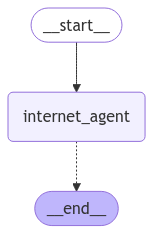

In [7]:
# Flow

# Initialize the workflow state graph
workflow = StateGraph(MessagesState)

# Add nodes to the workflow
workflow.add_node("internet_agent", internet_node)  
workflow.add_edge(START, "internet_agent")  # Connect the START node to the internet agent node

graph = workflow.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Failed to render the graph visualization: {e}")


In [8]:
# Main


query = "What is apple stock health on 22 Jan 2025"

inputs = {"messages": [("user", query)]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is apple stock health on 22 Jan 2025
================================ Human Message =================================
Name: internet_agent

On January 22, 2025, Apple Inc. was close to reaching a deal with the Indonesian government to lift a ban on domestic sales of its flagship iPhone. This ban had been in place since October 2024 due to Apple’s non-compliance with Indonesian local manufacturing and investment requirements. The company has been negotiating with the government regarding an investment package which aims to enable them to sell the iPhone in Indonesia again.

As of the reported date, Apple's stock was trading at approximately **$222.64**, experiencing a decline of **0.46%**. Additionally, the overall market sentiment was mixed, reflecting various pressures and influences on tech stocks at that time.

Here are some URLs for further reading:
1. [Apple close to reaching deal to lift Indone